In [51]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

List of Tickers

In [85]:
# tickers = ["ITSA4.SA", "ITUB4.SA","WEGE3.SA","PETR3.SA","AZUL4.SA", "B3SA3.SA","VALE3.SA","ABEV3.SA", "ALPA4.SA","BBAS3.SA","SUZB3.SA"]

tickers = [
    "ABEV3.SA", "ALPA4.SA", "AMER3.SA", "ASAI3.SA", "AZUL4.SA", "B3SA3.SA",
    "BBAS3.SA", "BBDC3.SA", "BBDC4.SA", "BBSE3.SA", "BPAC11.SA", "BRAP4.SA",
    "BRFS3.SA", "BRKM5.SA", "BRML3.SA", "CASH3.SA", "CCRO3.SA", "CIEL3.SA",
    "CMIG4.SA", "COGN3.SA", "CPFE3.SA", "CPLE6.SA", "CRFB3.SA", "CSAN3.SA",
    "CSNA3.SA", "CYRE3.SA", "DXCO3.SA", "ELET3.SA", "ELET6.SA", "EMBR3.SA",
    "ENGI11.SA", "EQTL3.SA", "EZTC3.SA", "GGBR4.SA", "GOAU4.SA", "GOLL4.SA",
    "HAPV3.SA", "HYPE3.SA", "IGTI11.SA", "ITSA4.SA", "ITUB4.SA", "JBSS3.SA",
    "KLBN11.SA", "LREN3.SA", "MGLU3.SA", "MRFG3.SA", "MRVE3.SA", "MULT3.SA",
    "NTCO3.SA", "PETR3.SA", "PETR4.SA", "PRIO3.SA", "RADL3.SA", "RAIL3.SA",
    "RENT3.SA", "RRRP3.SA", "SANB11.SA", "SBSP3.SA", "SMTO3.SA", "SOMA3.SA",
    "SUZB3.SA", "TAEE11.SA", "TIMS3.SA", "UGPA3.SA", "USIM5.SA", "VALE3.SA",
    "VBBR3.SA", "VIIA3.SA", "VIVT3.SA", "WEGE3.SA", "YDUQ3.SA"
]

In [86]:
raw_data = yf.download(tickers, start="2024-01-01", end="2025-10-01")

tickers_to_remove = [
    t for t in raw_data.columns.get_level_values(1).unique()
    if raw_data.xs(t, axis=1, level=1).isnull().any().any()
]

data = raw_data.drop(columns=tickers_to_remove, level=1)
tickers = [t for t in tickers if t not in tickers_to_remove]

print("Tickers removidos:", tickers_to_remove)

print(data.head())

C:\Users\airto\AppData\Local\Temp\ipykernel_37448\2576980432.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(tickers, start="2024-01-01", end="2025-10-01")
[*********************100%***********************]  71 of 71 completed

10 Failed downloads:
['VIIA3.SA', 'GOLL4.SA', 'JBSS3.SA', 'CIEL3.SA', 'RRRP3.SA', 'NTCO3.SA', 'SOMA3.SA', 'BRML3.SA', 'CRFB3.SA', 'CCRO3.SA']: YFTzMissingError('possibly delisted; no timezone found')


Tickers removidos: ['BRML3.SA', 'CCRO3.SA', 'CIEL3.SA', 'CRFB3.SA', 'GOLL4.SA', 'JBSS3.SA', 'NTCO3.SA', 'RRRP3.SA', 'SOMA3.SA', 'VIIA3.SA', 'BRFS3.SA', 'CPLE6.SA']
Price           Close                                                    \
Ticker       ABEV3.SA  ALPA4.SA AMER3.SA   ASAI3.SA AZUL4.SA   B3SA3.SA   
Date                                                                      
2024-01-02  12.496864  9.157123     90.0  12.787717    14.70  13.492297   
2024-01-03  12.396598  9.432525     90.0  12.709144    14.21  13.454209   
2024-01-04  12.442174  8.822705     88.0  12.974327    13.84  13.063819   
2024-01-05  12.396598  9.225972     87.0  13.337727    13.83  13.301863   
2024-01-08  12.496864  9.530882     87.0  13.917201    14.89  13.597034   

Price                                                   ...   Volume  \
Ticker       BBAS3.SA   BBDC3.SA   BBDC4.SA   BBSE3.SA  ... SUZB3.SA   
Date                                                    ...            
2024-01-02  24.2276

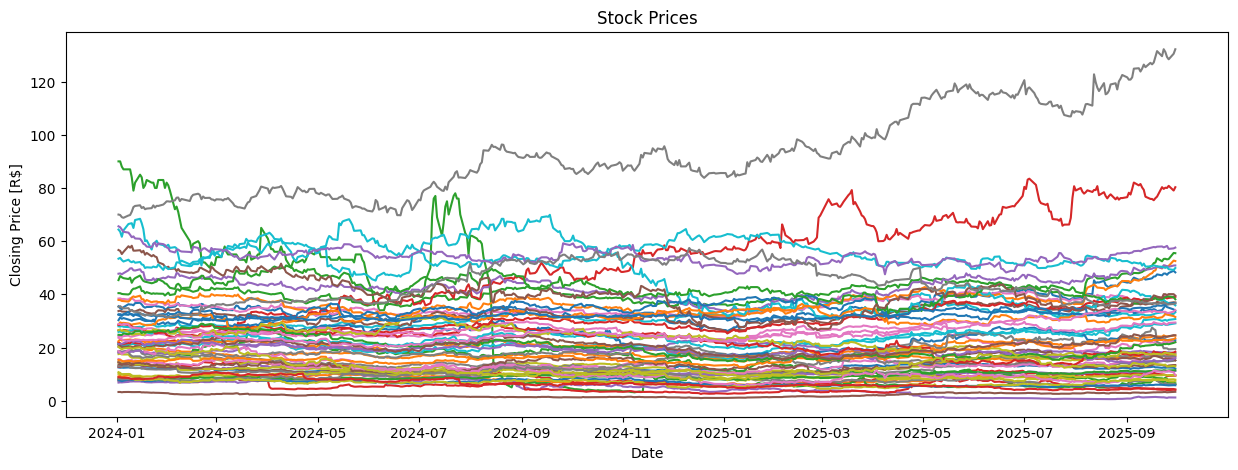

In [87]:
plt.figure(figsize=(15,5))

for ticker in tickers:
    plt.plot(data.index, data["Close", ticker], label=ticker)

plt.xlabel("Date")
plt.ylabel("Closing Price [R$]")
plt.title("Stock Prices")

plt.show()

In [88]:
keys = ["ticker", "cumulative_return_period","return_std_deviation"]
metrics = {key: [] for key in keys}

for ticker in tickers:
    close_values = data[('Close', ticker)]
    close_values = close_values.reset_index(drop=True)

    cumulative_return_period = (close_values.iloc[-1])-(close_values.iloc[0])
    daily_return = close_values.diff()
    return_std_deviation = daily_return.std()

    metrics["ticker"].append(ticker)
    metrics["cumulative_return_period"].append(cumulative_return_period)
    metrics["return_std_deviation"].append(return_std_deviation)

df = pd.DataFrame(metrics)
print(df)

       ticker  cumulative_return_period  return_std_deviation
0    ABEV3.SA                 -0.406864              0.158479
1    ALPA4.SA                  0.262877              0.189092
2    AMER3.SA                -83.890000              2.222188
3    ASAI3.SA                 -3.277717              0.257993
4    AZUL4.SA                -13.500000              0.288020
5    B3SA3.SA                 -0.092298              0.227947
6    BBAS3.SA                 -2.137684              0.355983
7    BBDC3.SA                  2.295737              0.188591
8    BBDC4.SA                  3.297011              0.233393
9    BBSE3.SA                  5.284281              0.358244
10  BPAC11.SA                 12.772163              0.617979
11   BRAP4.SA                 -4.456017              0.230835
12   BRKM5.SA                -14.530000              0.484173
13   CASH3.SA                 -3.479870              0.311156
14   CMIG4.SA                  4.333755              0.139179
15   COG

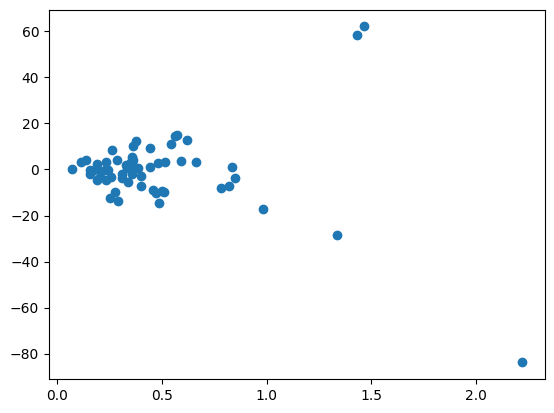

In [91]:
plt.scatter(df["return_std_deviation"],df["cumulative_return_period"])
plt.show()

In [92]:
X = df[["cumulative_return_period", "return_std_deviation"]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [105]:
k = 8
kmeans = KMeans(n_clusters=k, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

In [106]:
cluster_stats = df.groupby('cluster')[["cumulative_return_period", "return_std_deviation"]].mean()
cluster_stats['score'] = cluster_stats["cumulative_return_period"] / cluster_stats["return_std_deviation"]

print("Desempenho médio por cluster:")
print(cluster_stats)

Desempenho médio por cluster:
         cumulative_return_period  return_std_deviation      score
cluster                                                           
0                        9.556642              0.524372  18.224929
1                      -10.048143              0.397620 -25.270728
2                      -83.890000              2.222188 -37.751076
3                       60.232761              1.450408  41.528152
4                       -0.337225              0.184451  -1.828268
5                      -28.500000              1.336646 -21.322021
6                        1.538812              0.356479   4.316698
7                       -6.923652              0.853957  -8.107732


In [107]:
best_cluster = cluster_stats['score'].idxmax()
df['recomendado'] = df['cluster'] == best_cluster

print("\nAções recomendadas:")
print(df[df['recomendado']][['ticker', "cumulative_return_period", "return_std_deviation"]])


Ações recomendadas:
      ticker  cumulative_return_period  return_std_deviation
23  EMBR3.SA                 58.292633              1.433319
47  SBSP3.SA                 62.172890              1.467497


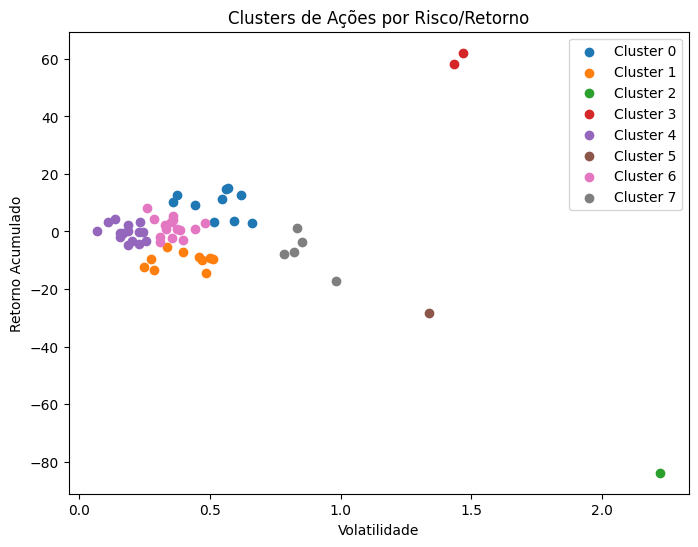

In [108]:
plt.figure(figsize=(8,6))
for c in range(k):
    subset = df[df['cluster'] == c]
    plt.scatter(subset["return_std_deviation"], subset["cumulative_return_period"], label=f'Cluster {c}')
plt.xlabel('Volatilidade')
plt.ylabel('Retorno Acumulado')
plt.title('Clusters de Ações por Risco/Retorno')
plt.legend()
plt.show()